In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import fsolve

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


## DATA

In [4]:
title = "LQ down 1200 GeV"

In [5]:
##############
# input data #
##############

# b1,b2 -> (pT, eta, phi) from the leading and second b-tagged jets
# tau -> (pT, eta, phi) from the tau
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets, num_btag)  HT: sum PT of all the jets, number of jets (b-tag or not), number of b-tagged jets


################
# New Physics: #
################

datFolderNP = '../DATA/signal/dats-LQdown-1200GeV/'
k_LQdown = 1.8247261601649074
crossfidNP = 0.0458318144*k_LQdown

b1_NP = np.loadtxt(datFolderNP + 'b1.dat', delimiter=' ')
b2_NP = np.loadtxt(datFolderNP + 'b2.dat', delimiter=' ')
tau_NP = np.loadtxt(datFolderNP + 'tau.dat', delimiter=' ')
MET_NP = np.loadtxt(datFolderNP + 'MET.dat', delimiter=' ')
hadinfo_NP = np.loadtxt(datFolderNP + 'hadinfo.dat', delimiter=' ')

print('# eventos LQ: ', len(b1_NP))



###############
# Background: #
###############

# tt and fakett

datFolderSM_tt = '../DATA/background/dats-tt/'

k_fakett = 1.1053030485310749
crossfid_fakett = 0.19136
k_tt = 1.2593273872014419
crossfid_tt = (5.1373984*k_tt) + (crossfid_fakett * k_fakett)

b1_SM_tt = np.loadtxt(datFolderSM_tt + 'b1.dat', delimiter=' ')
b2_SM_tt = np.loadtxt(datFolderSM_tt + 'b2.dat', delimiter=' ')
tau_SM_tt = np.loadtxt(datFolderSM_tt + 'tau.dat', delimiter=' ')
MET_SM_tt = np.loadtxt(datFolderSM_tt + 'MET.dat', delimiter=' ')
hadinfo_SM_tt = np.loadtxt(datFolderSM_tt + 'hadinfo.dat', delimiter=' ')

print('# eventos tt: ', len(b1_SM_tt))


# singlet part 1

datFolderSM_singletP1 = '../DATA/background/dats-singletP1/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP1 = 0.39648*k_singletTOTAL

b1_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b1.dat', delimiter=' ')
b2_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b2.dat', delimiter=' ')
tau_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'tau.dat', delimiter=' ')
MET_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 1: ', len(b1_SM_singletP1))


# singlet part 2

datFolderSM_singletP2 = '../DATA/background/dats-singlet-comp/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP2 = 0.283008*k_singletTOTAL

b1_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b1.dat', delimiter=' ')
b2_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b2.dat', delimiter=' ')
tau_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'tau.dat', delimiter=' ')
MET_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 2: ', len(b1_SM_singletP2))


# Wbbjets

datFolderSM_Wbbjets = '../DATA/background/dats-Wbbjets/'
k_wjets = 0.9781509289273502
crossfid_Wbbjets = 0.9988452079186325*k_wjets

b1_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b1.dat', delimiter=' ')
b2_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b2.dat', delimiter=' ')
tau_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'tau.dat', delimiter=' ')
MET_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'MET.dat', delimiter=' ')
hadinfo_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'hadinfo.dat', delimiter=' ')

print('# eventos Wbbjets: ', len(b1_SM_Wbbjets))


# ttW (part of ttV)

datFolderSM_ttW = '../DATA/background/dats-ttW/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttW = 0.0231785208*k_ttV

b1_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b1.dat', delimiter=' ')
b2_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b2.dat', delimiter=' ')
tau_SM_ttW = np.loadtxt(datFolderSM_ttW + 'tau.dat', delimiter=' ')
MET_SM_ttW = np.loadtxt(datFolderSM_ttW + 'MET.dat', delimiter=' ')
hadinfo_SM_ttW = np.loadtxt(datFolderSM_ttW + 'hadinfo.dat', delimiter=' ')

print('# eventos ttW: ', len(b1_SM_ttW))


# ttZ

datFolderSM_ttZ = '../DATA/background/dats-ttZ/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttZ = 0.050087088*k_ttV

b1_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b1.dat', delimiter=' ')
b2_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b2.dat', delimiter=' ')
tau_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'tau.dat', delimiter=' ')
MET_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'MET.dat', delimiter=' ')
hadinfo_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'hadinfo.dat', delimiter=' ')

print('# eventos ttZ: ', len(b1_SM_ttZ))


# ttH

datFolderSM_ttH = '../DATA/background/dats-ttH/'
k_ttH = 2.2127445612386474
crossfid_ttH = 0.025004896*k_ttH

b1_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b1.dat', delimiter=' ')
b2_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b2.dat', delimiter=' ')
tau_SM_ttH = np.loadtxt(datFolderSM_ttH + 'tau.dat', delimiter=' ')
MET_SM_ttH = np.loadtxt(datFolderSM_ttH + 'MET.dat', delimiter=' ')
hadinfo_SM_ttH = np.loadtxt(datFolderSM_ttH + 'hadinfo.dat', delimiter=' ')

print('# eventos ttH: ', len(b1_SM_ttH))

# eventos LQ:  494133
# eventos tt:  826022
# eventos singlet part 1:  179677
# eventos singlet part 2:  94219
# eventos Wbbjets:  162448
# eventos ttW:  141919
# eventos ttZ:  16178
# eventos ttH:  12068


In [6]:
# Number of data points (per-class) for the ML classifier
num_data_NP = int(len(b1_NP)-1)
print(' SIGNAL ')
print('# S chosen: ', num_data_NP)



totalcrossSM = crossfid_tt + crossfid_singletP1+crossfid_singletP2 + crossfid_Wbbjets + crossfid_ttW+crossfid_ttZ + crossfid_ttH

num_data_SM_singletP1 = round( num_data_NP * (crossfid_singletP1/totalcrossSM) )
num_data_SM_singletP2 = round( num_data_NP * (crossfid_singletP2/totalcrossSM) )
num_data_SM_Wbbjets = round( num_data_NP * (crossfid_Wbbjets/totalcrossSM) )
num_data_SM_ttW = round( num_data_NP * (crossfid_ttW/totalcrossSM) )
num_data_SM_ttZ = round( num_data_NP * (crossfid_ttZ/totalcrossSM) )
num_data_SM_ttH = round( num_data_NP * (crossfid_ttH/totalcrossSM) )

num_data_SM_tt = num_data_NP - (num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ + num_data_SM_ttH)

num_data_SM = num_data_SM_tt + num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ +  num_data_SM_ttH


print('\n BACKGROUND ')
print('# tt chosen: ', num_data_SM_tt)
print('# singletP1 chosen: ', num_data_SM_singletP1)
print('# singletP2 chosen: ', num_data_SM_singletP2)
print('# Wbbjets chosen: ', num_data_SM_Wbbjets)
print('# ttW chosen: ', num_data_SM_ttW)
print('# ttZ chosen: ', num_data_SM_ttZ)
print('# ttH chosen: ', num_data_SM_ttH)

print('\n# total B eventos chosen: ', num_data_SM)



# CHECK IF THE NUMBER OF EVENTS ARE CORRECT
if num_data_SM == num_data_NP and num_data_NP < len(b1_NP) and num_data_SM_tt < len(b1_SM_tt) and num_data_SM_singletP1 < len(b1_SM_singletP1) and num_data_SM_singletP2 < len(b1_SM_singletP2) and num_data_SM_Wbbjets < len(b1_SM_Wbbjets) and num_data_SM_ttW < len(b1_SM_ttW) and num_data_SM_ttZ < len(b1_SM_ttZ) and num_data_SM_ttH < len(b1_SM_ttH):
    print( '\nEverything OK, continue')
else:
    print( '\nThe number of events of each channel not enought, check if you need to generate more')

 SIGNAL 
# S chosen:  494132

 BACKGROUND 
# tt chosen:  321291
# singletP1 chosen:  65601
# singletP2 chosen:  46826
# Wbbjets chosen:  46984
# ttW chosen:  3407
# ttZ chosen:  7362
# ttH chosen:  2661

# total B eventos chosen:  494132

Everything OK, continue


In [7]:
# KEEP ONLY THE NUMBER OF SIGNAL EVENTS THAT WE WILL USE
b1_NP = b1_NP[:num_data_NP]
b2_NP = b2_NP[:num_data_NP]
tau_NP = tau_NP[:num_data_NP]
MET_NP = MET_NP[:num_data_NP]
hadinfo_NP = hadinfo_NP[:num_data_NP]


# CONCATENATE YOUR SELECTED BACKGROUNDS (as many as you want, with the correct proportion)

b1_SM = np.concatenate((b1_SM_tt[:num_data_SM_tt],b1_SM_singletP1[:num_data_SM_singletP1],b1_SM_singletP2[:num_data_SM_singletP2],b1_SM_Wbbjets[:num_data_SM_Wbbjets],b1_SM_ttW[:num_data_SM_ttW],b1_SM_ttZ[:num_data_SM_ttZ],b1_SM_ttH[:num_data_SM_ttH]))
b2_SM = np.concatenate((b2_SM_tt[:num_data_SM_tt],b2_SM_singletP1[:num_data_SM_singletP1],b2_SM_singletP2[:num_data_SM_singletP2],b2_SM_Wbbjets[:num_data_SM_Wbbjets],b2_SM_ttW[:num_data_SM_ttW],b2_SM_ttZ[:num_data_SM_ttZ],b2_SM_ttH[:num_data_SM_ttH]))
tau_SM = np.concatenate((tau_SM_tt[:num_data_SM_tt],tau_SM_singletP1[:num_data_SM_singletP1],tau_SM_singletP2[:num_data_SM_singletP2],tau_SM_Wbbjets[:num_data_SM_Wbbjets],tau_SM_ttW[:num_data_SM_ttW],tau_SM_ttZ[:num_data_SM_ttZ],tau_SM_ttH[:num_data_SM_ttH]))
MET_SM = np.concatenate((MET_SM_tt[:num_data_SM_tt],MET_SM_singletP1[:num_data_SM_singletP1],MET_SM_singletP2[:num_data_SM_singletP2],MET_SM_Wbbjets[:num_data_SM_Wbbjets],MET_SM_ttW[:num_data_SM_ttW],MET_SM_ttZ[:num_data_SM_ttZ],MET_SM_ttH[:num_data_SM_ttH]))
hadinfo_SM = np.concatenate((hadinfo_SM_tt[:num_data_SM_tt],hadinfo_SM_singletP1[:num_data_SM_singletP1],hadinfo_SM_singletP2[:num_data_SM_singletP2],hadinfo_SM_Wbbjets[:num_data_SM_Wbbjets],hadinfo_SM_ttW[:num_data_SM_ttW],hadinfo_SM_ttZ[:num_data_SM_ttZ],hadinfo_SM_ttH[:num_data_SM_ttH]))

del b1_SM_tt
del b2_SM_tt
del tau_SM_tt
del MET_SM_tt
del hadinfo_SM_tt

del b1_SM_singletP1
del b2_SM_singletP1
del tau_SM_singletP1
del MET_SM_singletP1
del hadinfo_SM_singletP1

del b1_SM_singletP2
del b2_SM_singletP2
del tau_SM_singletP2
del MET_SM_singletP2
del hadinfo_SM_singletP2

del b1_SM_Wbbjets
del b2_SM_Wbbjets
del tau_SM_Wbbjets
del MET_SM_Wbbjets
del hadinfo_SM_Wbbjets

del b1_SM_ttW
del b2_SM_ttW
del tau_SM_ttW
del MET_SM_ttW
del hadinfo_SM_ttW

del b1_SM_ttZ
del b2_SM_ttZ
del tau_SM_ttZ
del MET_SM_ttZ
del hadinfo_SM_ttZ

del b1_SM_ttH
del b2_SM_ttH
del tau_SM_ttH
del MET_SM_ttH
del hadinfo_SM_ttH

In [8]:
print('# Background events: ', len(b1_SM))
print('# Signal events: ', len(b1_NP))

# Background events:  494132
# Signal events:  494132


### pdfs

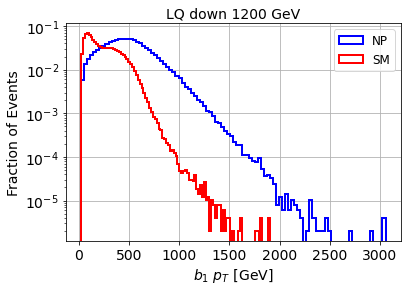

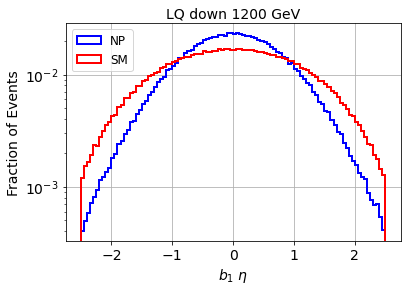

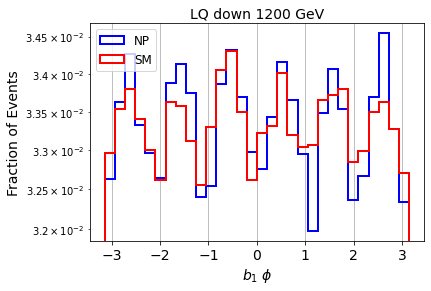

In [9]:
weights = np.ones_like(b1_NP[:,0])/float(len(b1_NP[:,0]))
plt.hist(b1_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,0])/float(len(b1_SM[:,0]))
plt.hist(b1_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,1])/float(len(b1_NP[:,1]))
plt.hist(b1_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,1])/float(len(b1_SM[:,1]))
plt.hist(b1_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,2])/float(len(b1_NP[:,2]))
plt.hist(b1_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,2])/float(len(b1_SM[:,2]))
plt.hist(b1_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

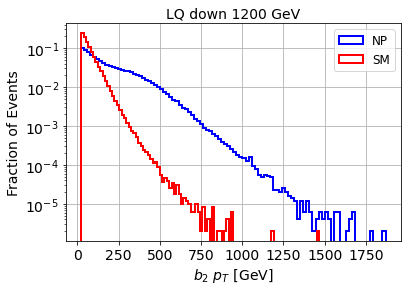

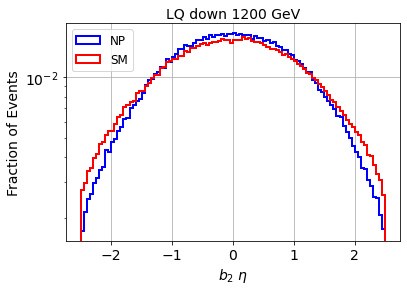

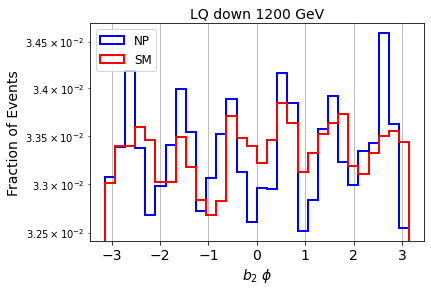

In [10]:
weights = np.ones_like(b2_NP[:,0])/float(len(b2_NP[:,0]))
plt.hist(b2_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,0])/float(len(b2_SM[:,0]))
plt.hist(b2_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,1])/float(len(b2_NP[:,1]))
plt.hist(b2_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,1])/float(len(b2_SM[:,1]))
plt.hist(b2_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,2])/float(len(b2_NP[:,2]))
plt.hist(b2_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,2])/float(len(b2_SM[:,2]))
plt.hist(b2_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

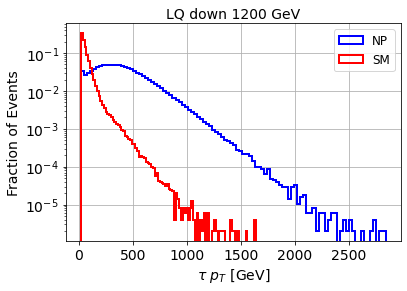

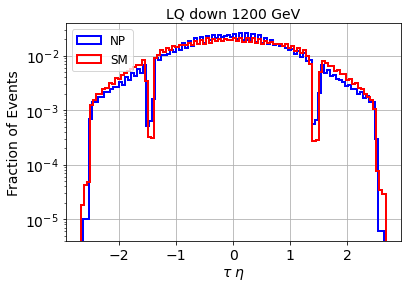

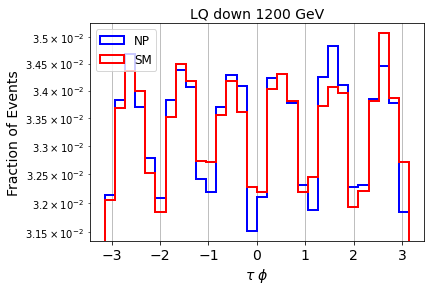

In [11]:
weights = np.ones_like(tau_NP[:,0])/float(len(tau_NP[:,0]))
plt.hist(tau_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,0])/float(len(tau_SM[:,0]))
plt.hist(tau_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,1])/float(len(tau_NP[:,1]))
plt.hist(tau_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,1])/float(len(tau_SM[:,1]))
plt.hist(tau_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,2])/float(len(tau_NP[:,2]))
plt.hist(tau_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,2])/float(len(tau_SM[:,2]))
plt.hist(tau_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

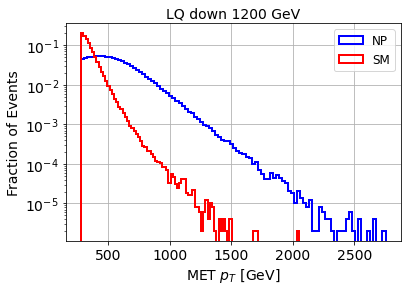

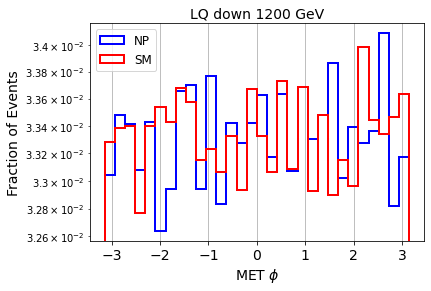

In [12]:
weights = np.ones_like(MET_NP[:,0])/float(len(MET_NP[:,0]))
plt.hist(MET_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,0])/float(len(MET_SM[:,0]))
plt.hist(MET_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()


weights = np.ones_like(MET_NP[:,2])/float(len(MET_NP[:,2]))
plt.hist(MET_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,2])/float(len(MET_SM[:,2]))
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

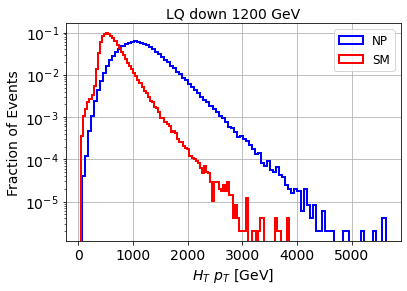

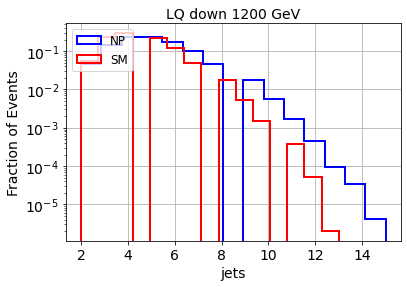

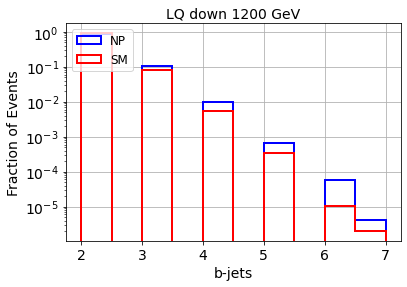

In [13]:
weights = np.ones_like(hadinfo_NP[:,0])/float(len(hadinfo_NP[:,0]))
plt.hist(hadinfo_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,0])/float(len(hadinfo_SM[:,0]))
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$H_T$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,1])/float(len(hadinfo_NP[:,1]))
plt.hist(hadinfo_NP[:,1], weights=weights, bins=15, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,1])/float(len(hadinfo_SM[:,1]))
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,2])/float(len(hadinfo_NP[:,2]))
plt.hist(hadinfo_NP[:,2], weights=weights, bins=10, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,2])/float(len(hadinfo_SM[:,2]))
plt.hist(hadinfo_SM[:,2], weights=weights, bins=10, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("b-jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

### Train-test-val Dataset

In [14]:
# to normalize
scaler = preprocessing.MinMaxScaler()



df = pd.DataFrame()

df['b1-pt']= np.concatenate([b1_SM[:,0],b1_NP[:,0]])
df['b1-eta']= np.concatenate([b1_SM[:,1],b1_NP[:,1]])
df['b1-phi']= np.concatenate([b1_SM[:,2],b1_NP[:,2]])
# remove the used data
del b1_SM
del b1_NP

df['b2-pt']= np.concatenate([b2_SM[:,0],b2_NP[:,0]])
df['b2-eta']= np.concatenate([b2_SM[:,1],b2_NP[:,1]])
df['b2-phi']= np.concatenate([b2_SM[:,2],b2_NP[:,2]])
# remove the used dat
del b2_SM
del b2_NP

df['tau-pt']= np.concatenate([tau_SM[:,0],tau_NP[:,0]])
df['tau-eta']= np.concatenate([tau_SM[:,1],tau_NP[:,1]])
df['tau-phi']= np.concatenate([tau_SM[:,2],tau_NP[:,2]])
# remove the used data
del tau_SM
del tau_NP

df['MET-pt']= np.concatenate([MET_SM[:,0],MET_NP[:,0]])
df['MET-phi']= np.concatenate([MET_SM[:,2],MET_NP[:,2]])
# remove the used data
del MET_SM
del MET_NP

df['HT-pt']= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[:,0]])
df['num-jets']= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[:,1]])
df['num-bjets']= np.concatenate([hadinfo_SM[:,2],hadinfo_NP[:,2]])
# remove the used data
del hadinfo_SM
del hadinfo_NP

df['Y'] = np.concatenate([np.zeros(num_data_SM),np.ones(num_data_NP)])





# NORMALIZE
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# print df to see the data
print(df)


# X and Y for the classifier
X_mon = df[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mon = df[['Y']].values


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)


print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

           b1-pt    b1-eta    b1-phi     b2-pt    b2-eta    b2-phi    tau-pt  \
0       0.008114  0.639656  0.978199  0.002931  0.475990  0.432368  0.005583   
1       0.018101  0.184874  0.496181  0.024198  0.532013  0.058243  0.001867   
2       0.032595  0.628651  0.564290  0.011452  0.573629  0.929822  0.010320   
3       0.077359  0.276110  0.337842  0.069360  0.332533  0.454806  0.024286   
4       0.038134  0.747299  0.141948  0.011766  0.855342  0.447804  0.005792   
...          ...       ...       ...       ...       ...       ...       ...   
988259  0.109324  0.751301  0.495226  0.124257  0.505002  0.556015  0.228271   
988260  0.091780  0.546018  0.850891  0.126673  0.661064  0.913113  0.241193   
988261  0.188104  0.284914  0.900223  0.056169  0.638455  0.017346  0.148887   
988262  0.202996  0.378952  0.015913  0.294141  0.380352  0.398472  0.125145   
988263  0.145321  0.315126  0.974539  0.044609  0.232293  0.889561  0.073414   

         tau-eta   tau-phi    MET-pt   

### XGBoost (per-event)

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.61473	validation_1-logloss:0.61479
[1]	validation_0-logloss:0.55041	validation_1-logloss:0.55047
[2]	validation_0-logloss:0.49653	validation_1-logloss:0.49685
[3]	validation_0-logloss:0.45145	validation_1-logloss:0.45169
[4]	validation_0-logloss:0.41257	validation_1-logloss:0.41296
[5]	validation_0-logloss:0.37916	validation_1-logloss:0.37952
[6]	validation_0-logloss:0.35019	validation_1-logloss:0.35065
[7]	validation_0-logloss:0.32499	validation_1-logloss:0.32547
[8]	validation_0-logloss:0.30286	validation_1-logloss:0.30332
[9]	validation_0-logloss:0.28334	validation_1-logloss:0.28390
[10]	validation_0-logloss:0.26614	validation_1-logloss:0.26671
[11]	validation_0-logloss:0.25103	validation_1-logloss:0.25161
[12]	validation_0-logloss:0.23754	validation_1-logloss:0.23818
[13]	validation_0-logloss:0.22562	validation_1-logloss:0.22628
[14]	validation_0-logloss:0.21505	validation_1-logloss:0.21576
[15]	validation_0-logloss:0.20563	validation_1-logloss:0.20634
[1

[130]	validation_0-logloss:0.10485	validation_1-logloss:0.10940
[131]	validation_0-logloss:0.10480	validation_1-logloss:0.10937
[132]	validation_0-logloss:0.10476	validation_1-logloss:0.10936
[133]	validation_0-logloss:0.10472	validation_1-logloss:0.10935
[134]	validation_0-logloss:0.10466	validation_1-logloss:0.10932
[135]	validation_0-logloss:0.10444	validation_1-logloss:0.10912
[136]	validation_0-logloss:0.10440	validation_1-logloss:0.10911
[137]	validation_0-logloss:0.10430	validation_1-logloss:0.10902
[138]	validation_0-logloss:0.10428	validation_1-logloss:0.10901
[139]	validation_0-logloss:0.10423	validation_1-logloss:0.10899
[140]	validation_0-logloss:0.10420	validation_1-logloss:0.10899
[141]	validation_0-logloss:0.10416	validation_1-logloss:0.10898
[142]	validation_0-logloss:0.10411	validation_1-logloss:0.10896
[143]	validation_0-logloss:0.10407	validation_1-logloss:0.10895
[144]	validation_0-logloss:0.10401	validation_1-logloss:0.10892
[145]	validation_0-logloss:0.10394	valid

[259]	validation_0-logloss:0.08711	validation_1-logloss:0.09464
[260]	validation_0-logloss:0.08708	validation_1-logloss:0.09465
[261]	validation_0-logloss:0.08702	validation_1-logloss:0.09462
[262]	validation_0-logloss:0.08698	validation_1-logloss:0.09460
[263]	validation_0-logloss:0.08693	validation_1-logloss:0.09460
[264]	validation_0-logloss:0.08692	validation_1-logloss:0.09460
[265]	validation_0-logloss:0.08660	validation_1-logloss:0.09430
[266]	validation_0-logloss:0.08656	validation_1-logloss:0.09430
[267]	validation_0-logloss:0.08652	validation_1-logloss:0.09430
[268]	validation_0-logloss:0.08651	validation_1-logloss:0.09430
[269]	validation_0-logloss:0.08648	validation_1-logloss:0.09429
[270]	validation_0-logloss:0.08647	validation_1-logloss:0.09429
[271]	validation_0-logloss:0.08646	validation_1-logloss:0.09429
[272]	validation_0-logloss:0.08642	validation_1-logloss:0.09427
[273]	validation_0-logloss:0.08606	validation_1-logloss:0.09393
[274]	validation_0-logloss:0.08603	valid

[388]	validation_0-logloss:0.08003	validation_1-logloss:0.09036
[389]	validation_0-logloss:0.08001	validation_1-logloss:0.09036
[390]	validation_0-logloss:0.07994	validation_1-logloss:0.09032
[391]	validation_0-logloss:0.07992	validation_1-logloss:0.09033
[392]	validation_0-logloss:0.07990	validation_1-logloss:0.09033
[393]	validation_0-logloss:0.07986	validation_1-logloss:0.09031
[394]	validation_0-logloss:0.07985	validation_1-logloss:0.09032
[395]	validation_0-logloss:0.07956	validation_1-logloss:0.09006
[396]	validation_0-logloss:0.07953	validation_1-logloss:0.09006
[397]	validation_0-logloss:0.07950	validation_1-logloss:0.09006
[398]	validation_0-logloss:0.07948	validation_1-logloss:0.09006
[399]	validation_0-logloss:0.07945	validation_1-logloss:0.09006
[400]	validation_0-logloss:0.07910	validation_1-logloss:0.08974
[401]	validation_0-logloss:0.07907	validation_1-logloss:0.08974
[402]	validation_0-logloss:0.07904	validation_1-logloss:0.08974
[403]	validation_0-logloss:0.07902	valid

[517]	validation_0-logloss:0.07372	validation_1-logloss:0.08701
[518]	validation_0-logloss:0.07369	validation_1-logloss:0.08700
[519]	validation_0-logloss:0.07367	validation_1-logloss:0.08700
[520]	validation_0-logloss:0.07364	validation_1-logloss:0.08700
[521]	validation_0-logloss:0.07361	validation_1-logloss:0.08700
[522]	validation_0-logloss:0.07328	validation_1-logloss:0.08671
[523]	validation_0-logloss:0.07326	validation_1-logloss:0.08671
[524]	validation_0-logloss:0.07322	validation_1-logloss:0.08672
[525]	validation_0-logloss:0.07319	validation_1-logloss:0.08671
[526]	validation_0-logloss:0.07316	validation_1-logloss:0.08671
[527]	validation_0-logloss:0.07314	validation_1-logloss:0.08671
[528]	validation_0-logloss:0.07311	validation_1-logloss:0.08671
[529]	validation_0-logloss:0.07300	validation_1-logloss:0.08664
[530]	validation_0-logloss:0.07299	validation_1-logloss:0.08664
[531]	validation_0-logloss:0.07296	validation_1-logloss:0.08664
[532]	validation_0-logloss:0.07293	valid

[646]	validation_0-logloss:0.06950	validation_1-logloss:0.08551
[647]	validation_0-logloss:0.06949	validation_1-logloss:0.08551
[648]	validation_0-logloss:0.06947	validation_1-logloss:0.08551
[649]	validation_0-logloss:0.06947	validation_1-logloss:0.08551
[650]	validation_0-logloss:0.06947	validation_1-logloss:0.08551
[651]	validation_0-logloss:0.06945	validation_1-logloss:0.08551
[652]	validation_0-logloss:0.06942	validation_1-logloss:0.08551
[653]	validation_0-logloss:0.06940	validation_1-logloss:0.08551
[654]	validation_0-logloss:0.06938	validation_1-logloss:0.08551
[655]	validation_0-logloss:0.06936	validation_1-logloss:0.08551
[656]	validation_0-logloss:0.06936	validation_1-logloss:0.08551
[657]	validation_0-logloss:0.06936	validation_1-logloss:0.08551
[658]	validation_0-logloss:0.06935	validation_1-logloss:0.08551
[659]	validation_0-logloss:0.06934	validation_1-logloss:0.08552
[660]	validation_0-logloss:0.06933	validation_1-logloss:0.08552
[661]	validation_0-logloss:0.06933	valid

[775]	validation_0-logloss:0.06586	validation_1-logloss:0.08430
[776]	validation_0-logloss:0.06584	validation_1-logloss:0.08429
[777]	validation_0-logloss:0.06578	validation_1-logloss:0.08426
[778]	validation_0-logloss:0.06577	validation_1-logloss:0.08426
[779]	validation_0-logloss:0.06576	validation_1-logloss:0.08426
[780]	validation_0-logloss:0.06573	validation_1-logloss:0.08427
[781]	validation_0-logloss:0.06570	validation_1-logloss:0.08427
[782]	validation_0-logloss:0.06565	validation_1-logloss:0.08425
[783]	validation_0-logloss:0.06563	validation_1-logloss:0.08425
[784]	validation_0-logloss:0.06562	validation_1-logloss:0.08425
[785]	validation_0-logloss:0.06561	validation_1-logloss:0.08425
[786]	validation_0-logloss:0.06560	validation_1-logloss:0.08425
[787]	validation_0-logloss:0.06559	validation_1-logloss:0.08425
[788]	validation_0-logloss:0.06557	validation_1-logloss:0.08425
[789]	validation_0-logloss:0.06557	validation_1-logloss:0.08425
[790]	validation_0-logloss:0.06554	valid

[904]	validation_0-logloss:0.06262	validation_1-logloss:0.08331
[905]	validation_0-logloss:0.06261	validation_1-logloss:0.08332
[906]	validation_0-logloss:0.06259	validation_1-logloss:0.08331
[907]	validation_0-logloss:0.06259	validation_1-logloss:0.08331
[908]	validation_0-logloss:0.06256	validation_1-logloss:0.08329
[909]	validation_0-logloss:0.06255	validation_1-logloss:0.08329
[910]	validation_0-logloss:0.06254	validation_1-logloss:0.08329
[911]	validation_0-logloss:0.06251	validation_1-logloss:0.08330
[912]	validation_0-logloss:0.06250	validation_1-logloss:0.08330
[913]	validation_0-logloss:0.06248	validation_1-logloss:0.08331
[914]	validation_0-logloss:0.06246	validation_1-logloss:0.08331
[915]	validation_0-logloss:0.06244	validation_1-logloss:0.08331
[916]	validation_0-logloss:0.06244	validation_1-logloss:0.08332
[917]	validation_0-logloss:0.06243	validation_1-logloss:0.08332
[918]	validation_0-logloss:0.06240	validation_1-logloss:0.08332
[919]	validation_0-logloss:0.06238	valid

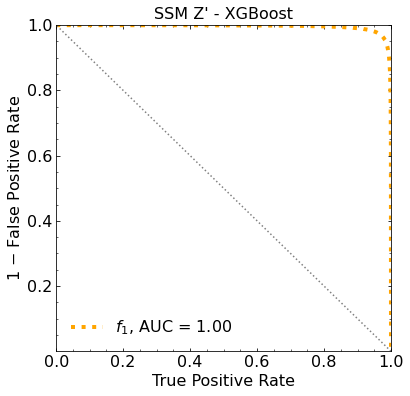

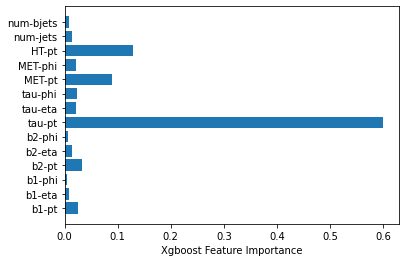

In [15]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




# THIS IS THE DEFAULT FEATURE IMPORTANCE: gain
feature_names = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])
plt.barh(feature_names, classifier.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

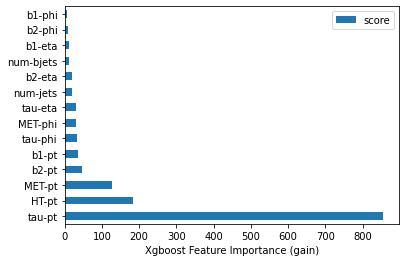

In [16]:
keys = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh') ## plot top 20 features
plt.xlabel("Xgboost Feature Importance (gain)")
plt.show()

Classification score:


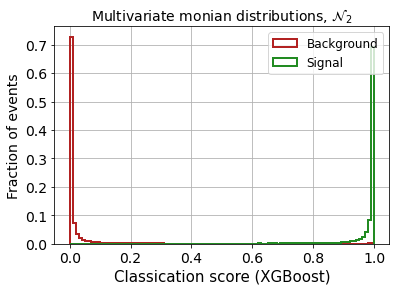

In [17]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate monian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

## METHODS

### 0. Ensembles characteristics

In [9]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = round(139 * totalcrossSM)    # luminosity * cross * aceptance
print('B_expected: ', B_expected)

print('S_expected: ', round(139 * crossfidNP))    # luminosity * cross * aceptance
S_expected = [1,3,5,7,10,20,50]




# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = [ S_expected[iii]/(1.*B_expected) for iii in range(len(S_expected)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(S_expected)) ]

B_expected:  1428
S_expected:  12


In [10]:
139 * crossfidNP

11.624640987786876

### 1. BIN LOG LIKELIHOOD

B_expected:  1428
S_expected:  1
S/$\sqrt{B}$:  0.026462806201248155

 If  285  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take a bit... 



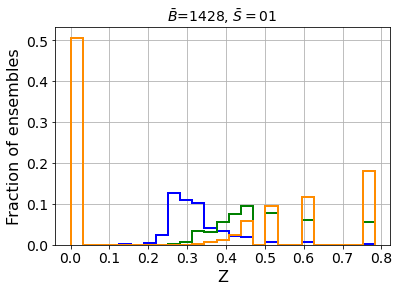

Z_bins_16bins:  0.0
Z_bins_16bins_std:  0.17155256878760455
Z_bins_50bins:  0.0
Z_bins_50bins_std:  0.26352346293962475
Z_bins_100bins:  0.0
Z_bins_100bins_std:  0.325413104384676

 -------------------------------- 

B_expected:  1428
S_expected:  3
S/$\sqrt{B}$:  0.07938841860374447

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take a bit... 



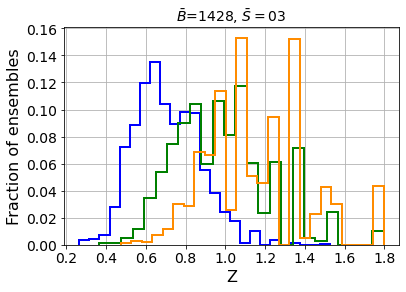

Z_bins_16bins:  0.6939726248688167
Z_bins_16bins_std:  0.16576154452506225
Z_bins_50bins:  0.9669778991290626
Z_bins_50bins_std:  0.23766435968509683
Z_bins_100bins:  1.1078859497981814
Z_bins_100bins_std:  0.2566123514044251

 -------------------------------- 

B_expected:  1428
S_expected:  5
S/$\sqrt{B}$:  0.13231403100624078

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1866

 This may take a bit... 



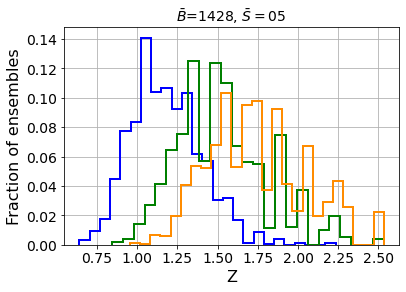

Z_bins_16bins:  1.1702725436609085
Z_bins_16bins_std:  0.2162479736927286
Z_bins_50bins:  1.4939460992595375
Z_bins_50bins_std:  0.2863673870235635
Z_bins_100bins:  1.7110897783450887
Z_bins_100bins_std:  0.305574085799279

 -------------------------------- 

B_expected:  1428
S_expected:  7
S/$\sqrt{B}$:  0.18523964340873708

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take a bit... 



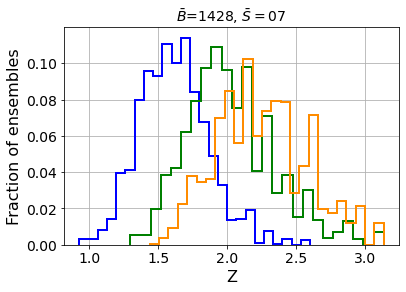

Z_bins_16bins:  1.6041179116262927
Z_bins_16bins_std:  0.2492098624091695
Z_bins_50bins:  2.0100697010652278
Z_bins_50bins_std:  0.3260219872846298
Z_bins_100bins:  2.2305908677618036
Z_bins_100bins_std:  0.3311522370046045

 -------------------------------- 

B_expected:  1428
S_expected:  10
S/$\sqrt{B}$:  0.26462806201248157

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take a bit... 



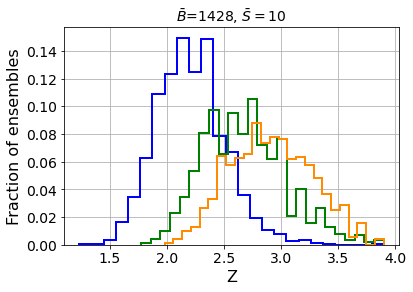

Z_bins_16bins:  2.1960835674022094
Z_bins_16bins_std:  0.29665599159846623
Z_bins_50bins:  2.656800931309259
Z_bins_50bins_std:  0.3603648987843614
Z_bins_100bins:  2.9015777922890087
Z_bins_100bins_std:  0.35906766932488027

 -------------------------------- 

B_expected:  1428
S_expected:  20
S/$\sqrt{B}$:  0.5292561240249631

 If  289  =  177    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take a bit... 



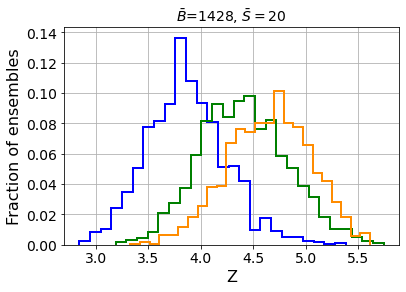

Z_bins_16bins:  3.846784329372297
Z_bins_16bins_std:  0.37792144901978003
Z_bins_50bins:  4.3995735647456256
Z_bins_50bins_std:  0.4169468982501547
Z_bins_100bins:  4.674060251687678
Z_bins_100bins_std:  0.39086806011574565

 -------------------------------- 

B_expected:  1428
S_expected:  50
S/$\sqrt{B}$:  1.3231403100624077

 If  295  =  178    then the proposed range has to be extended
n_ensembles (actual):  1863

 This may take a bit... 



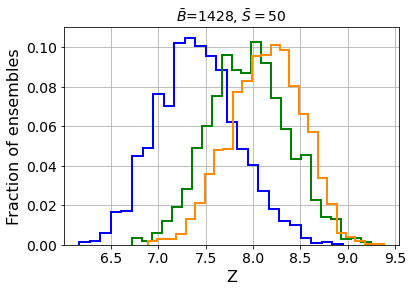

Z_bins_16bins:  7.3964932023559875
Z_bins_16bins_std:  0.4293635238489565
Z_bins_50bins:  7.9538683465396405
Z_bins_50bins_std:  0.4201589931060165
Z_bins_100bins:  8.15420700316453
Z_bins_100bins_std:  0.37927651341442586

 -------------------------------- 



In [20]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_16bins_std = []
store_Z_bins_XG_50bins_std = []
store_Z_bins_XG_100bins_std = []

# store_Z_bins_XG_16bins_noUnc = []
# store_Z_bins_XG_50bins_noUnc = []
# store_Z_bins_XG_100bins_noUnc = []

# store_Z_bins_XG_16bins_noUnc_std = []
# store_Z_bins_XG_50bins_noUnc_std = []
# store_Z_bins_XG_100bins_noUnc_std = []


indices_B = [i for i in range(len(pred_XG_SM))]
indices_S = [i for i in range(len(pred_XG_NP))]







for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    print('\n This may take a bit... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    Z_bins_16bins_aux = []
    Z_bins_50bins_aux = []
    Z_bins_100bins_aux = []
    
#     Z_bins_16bins_noUnc_aux = []
#     Z_bins_50bins_noUnc_aux = []
#     Z_bins_100bins_noUnc_aux = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            ran_ind_B = np.random.choice(indices_B, list_B_per_ensembles[bb])
            ran_ind_S = np.random.choice(indices_S, list_S_per_ensembles[bb])
            

            
            pred_XG_SM_shuf = []
            
            pred_XG_NP_shuf = []
            
            for ill in ran_ind_B:
                pred_XG_SM_shuf.append(pred_XG_SM[ill])
                
            for ill in ran_ind_S:
                pred_XG_NP_shuf.append(pred_XG_NP[ill])
                
            
            
            ############
            # 16 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:       

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(16), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(16), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_16bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_16bins_aux.append(Z_bins_16bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_16bins**2))/((back_prom_sig_16bins**2)+back_prom) ))**0.5 )

#             Z_bins_16bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_16bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_16bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_16bins_aux.append(Z_bins_16bins_sig)
            
            
            
            
            
            ############
            # 50 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(50), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(50), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_50bins_aux.append(Z_bins_50bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_50bins**2))/((back_prom_sig_50bins**2)+back_prom) ))**0.5 )

#             Z_bins_50bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_50bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_50bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_50bins_aux.append(Z_bins_50bins_sig)
        
        
        
        
        
        
            ############
            # 100 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(100), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(100), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_100bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_100bins_aux.append(Z_bins_100bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_100bins**2))/((back_prom_sig_100bins**2)+back_prom) ))**0.5 )

#             Z_bins_100bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_100bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_100bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_100bins_aux.append(Z_bins_100bins_sig)
            
    
    
    
  
    # Histogram of q_muhats

    weights = np.ones_like(Z_bins_16bins_aux)/float(len(Z_bins_16bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_16bins_aux, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    weights = np.ones_like(Z_bins_50bins_aux)/float(len(Z_bins_50bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_50bins_aux, 25, weights=weights, histtype='step', color='green', linewidth=2)
    weights = np.ones_like(Z_bins_100bins_aux)/float(len(Z_bins_100bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_100bins_aux, 25, weights=weights, histtype='step', color='darkorange', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Z",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()
    
    
    # 16 bins #
    # Remove nan if any
    Z_bins_16bins_aux = [x for x in Z_bins_16bins_aux if x == x]
    for jk in range(len(Z_bins_16bins_aux)):
        if Z_bins_16bins_aux[jk] < 0:
            Z_bins_16bins_aux[jk] = 0

    Z_bins_16bins = np.median(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins.append(Z_bins_16bins)
    
    Z_bins_16bins_std = np.std(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins_std.append(Z_bins_16bins_std)

    print('Z_bins_16bins: ', Z_bins_16bins)
    print('Z_bins_16bins_std: ', Z_bins_16bins_std)

    
#     # Remove nan if any
#     Z_bins_16bins_noUnc_aux = [x for x in Z_bins_16bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_16bins_noUnc_aux)):
#         if Z_bins_16bins_noUnc_aux[jk] < 0:
#             Z_bins_16bins_noUnc_aux[jk] = 0

#     Z_bins_16bins_noUnc = np.median(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc.append(Z_bins_16bins_noUnc)
    
#     Z_bins_16bins_noUnc_std = np.std(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc_std.append(Z_bins_16bins_noUnc_std)

#     print('Z_bins_16bins_noUnc: ', Z_bins_16bins_noUnc)
#     print('Z_bins_16bins_noUnc_std: ', Z_bins_16bins_noUnc_std)
    
    
    # 50 bins #
    # Remove nan if any
    Z_bins_50bins_aux = [x for x in Z_bins_50bins_aux if x == x]
    for jk in range(len(Z_bins_50bins_aux)):
        if Z_bins_50bins_aux[jk] < 0:
            Z_bins_50bins_aux[jk] = 0

    Z_bins_50bins = np.median(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins.append(Z_bins_50bins)
    
    Z_bins_50bins_std = np.std(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins_std.append(Z_bins_50bins_std)

    print('Z_bins_50bins: ', Z_bins_50bins)
    print('Z_bins_50bins_std: ', Z_bins_50bins_std)
    
    
#     # Remove nan if any
#     Z_bins_50bins_noUnc_aux = [x for x in Z_bins_50bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_50bins_noUnc_aux)):
#         if Z_bins_50bins_noUnc_aux[jk] < 0:
#             Z_bins_50bins_noUnc_aux[jk] = 0

#     Z_bins_50bins_noUnc = np.median(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc.append(Z_bins_50bins_noUnc)
    
#     Z_bins_50bins_noUnc_std = np.std(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc_std.append(Z_bins_50bins_noUnc_std)

#     print('Z_bins_50bins_noUnc: ', Z_bins_50bins_noUnc)
#     print('Z_bins_50bins_noUnc_std: ', Z_bins_50bins_noUnc_std)
    
    
    # 100 bins #
    # Remove nan if any
    Z_bins_100bins_aux = [x for x in Z_bins_100bins_aux if x == x]
    for jk in range(len(Z_bins_100bins_aux)):
        if Z_bins_100bins_aux[jk] < 0:
            Z_bins_100bins_aux[jk] = 0

    Z_bins_100bins = np.median(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins.append(Z_bins_100bins)
    
    Z_bins_100bins_std = np.std(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins_std.append(Z_bins_100bins_std)

    print('Z_bins_100bins: ', Z_bins_100bins)
    print('Z_bins_100bins_std: ', Z_bins_100bins_std)
    
    
#     # Remove nan if any
#     Z_bins_100bins_noUnc_aux = [x for x in Z_bins_100bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_100bins_noUnc_aux)):
#         if Z_bins_100bins_noUnc_aux[jk] < 0:
#             Z_bins_100bins_noUnc_aux[jk] = 0

#     Z_bins_100bins_noUnc = np.median(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc.append(Z_bins_100bins_noUnc)
    
#     Z_bins_100bins_noUnc_std = np.std(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc_std.append(Z_bins_100bins_noUnc_std)

#     print('Z_bins_100bins_noUnc: ', Z_bins_100bins_noUnc)
#     print('Z_bins_100bins_noUnc_std: ', Z_bins_100bins_noUnc_std)

    print('\n -------------------------------- \n')

In [21]:
print(store_Z_bins_XG_16bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_16bins_std)
print(store_Z_bins_XG_50bins_std)
print(store_Z_bins_XG_100bins_std)

[0.0, 0.6939726248688167, 1.1702725436609085, 1.6041179116262927, 2.1960835674022094, 3.846784329372297, 7.3964932023559875]
[0.0, 0.9669778991290626, 1.4939460992595375, 2.0100697010652278, 2.656800931309259, 4.3995735647456256, 7.9538683465396405]
[0.0, 1.1078859497981814, 1.7110897783450887, 2.2305908677618036, 2.9015777922890087, 4.674060251687678, 8.15420700316453]
[0.17155256878760455, 0.16576154452506225, 0.2162479736927286, 0.2492098624091695, 0.29665599159846623, 0.37792144901978003, 0.4293635238489565]
[0.26352346293962475, 0.23766435968509683, 0.2863673870235635, 0.3260219872846298, 0.3603648987843614, 0.4169468982501547, 0.4201589931060165]
[0.325413104384676, 0.2566123514044251, 0.305574085799279, 0.3311522370046045, 0.35906766932488027, 0.39086806011574565, 0.37927651341442586]


In [11]:
store_Z_bins_XG_16bins = [0.0, 0.6939726248688167, 1.1702725436609085, 1.6041179116262927, 2.1960835674022094, 3.846784329372297, 7.3964932023559875]
store_Z_bins_XG_50bins = [0.0, 0.9669778991290626, 1.4939460992595375, 2.0100697010652278, 2.656800931309259, 4.3995735647456256, 7.9538683465396405]
store_Z_bins_XG_100bins = [0.0, 1.1078859497981814, 1.7110897783450887, 2.2305908677618036, 2.9015777922890087, 4.674060251687678, 8.15420700316453]

store_Z_bins_XG_16bins_std = [0.17155256878760455, 0.16576154452506225, 0.2162479736927286, 0.2492098624091695, 0.29665599159846623, 0.37792144901978003, 0.4293635238489565]
store_Z_bins_XG_50bins_std = [0.26352346293962475, 0.23766435968509683, 0.2863673870235635, 0.3260219872846298, 0.3603648987843614, 0.4169468982501547, 0.4201589931060165]
store_Z_bins_XG_100bins_std =[0.325413104384676, 0.2566123514044251, 0.305574085799279, 0.3311522370046045, 0.35906766932488027, 0.39086806011574565, 0.37927651341442586]

In [12]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

In [13]:
store_muhat_mean_16bins = [0.2293006332288725, 0.03730167226484595, 0.012183041358383587, 0.012780424212065102, -0.002414444658209022, 0.004116631214746651, 0.00736394547691964]

store_Z_bins_XG_16bins_q = [0.26801395173531584, 0.7649536800999978, 1.2540916778942992, 1.6695702673649653, 2.231514803497347, 3.854776998625543, 7.285997145210817]
store_Z_bins_XG_16bins_std = [0.5457760278889441, 0.6302818223313199, 0.6751725741273881, 0.6891894299404161, 0.7170688719539808, 0.7135573475098094, 0.6488614557143831]

store_Z_bins_XG_16bins_mu0 = [0.26801395173531584, 0.7649536800999978, 1.2540916778942992, 1.6695702673649653, 2.231514803497347, 3.854776998625543, 7.283732198412269]
store_Z_bins_XG_16bins_std_mu0 = [0.5461571658394069, 0.6377721597859716, 0.6924649766047252, 0.7190396976456744, 0.7723818479965848, 0.8005165210761296, 0.7006974613453973]

In [14]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

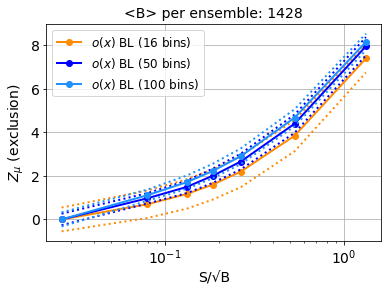

In [15]:
#########
# PLOTS #
#########

posX = []

for i in range(len(S_expected)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL KDE

#### KDE

/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
 12468.88941531 11745.85117718 10879.06941336  9879.23137373
  8751.15659588  7492.08397764  6118.76533806  4640.05395583
  3086.17250953  1484.71994144  -172.47368703 -1790.7285897 ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.005072980090653727, kernel='epanechnikov')


/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf 12345.96505298
 11850.00519194 11218.24250315 10449.40206361  9534.61118264
  8488.93239869  7320.68350358  6012.39076115  4602.44498772
  3099.16186604  1529.60637515  -111.81739111 -1763.23727761]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.0031053121543406503, kernel='epanechnikov')


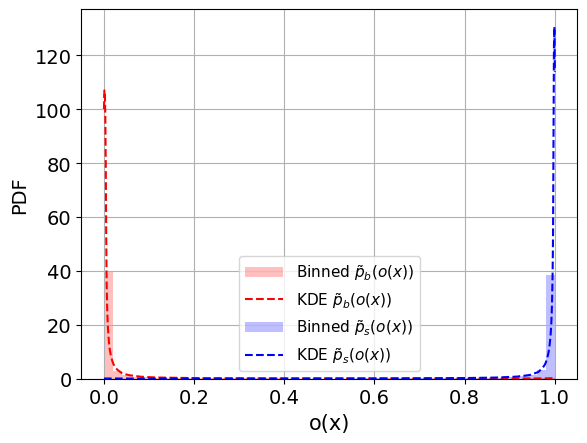

In [24]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

#SM_bandwidth = 0.0127
#NP_bandwidth = 0.0127

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

B_expected:  1428


/tmp/ipykernel_12791/4108206064.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
/tmp/ipykernel_12791/4108206064.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
/tmp/ipykernel_12791/4108206064.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)')


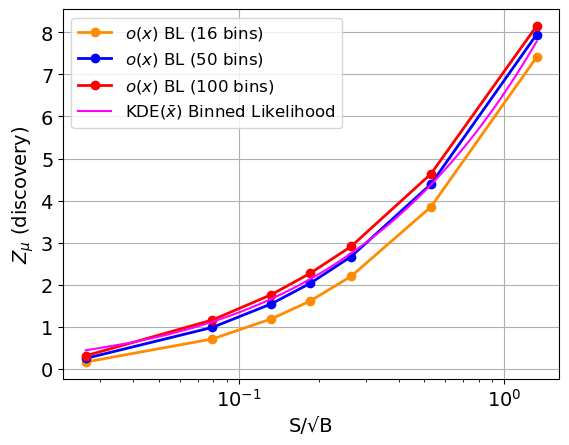

In [25]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### MLL KDE

In [26]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [27]:
KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

B_expected:  1428
S_expected:  1
S/$\sqrt{B}$:  0.026462806201248155
n_ensembles (initial):  2000

 If  285  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take long... 



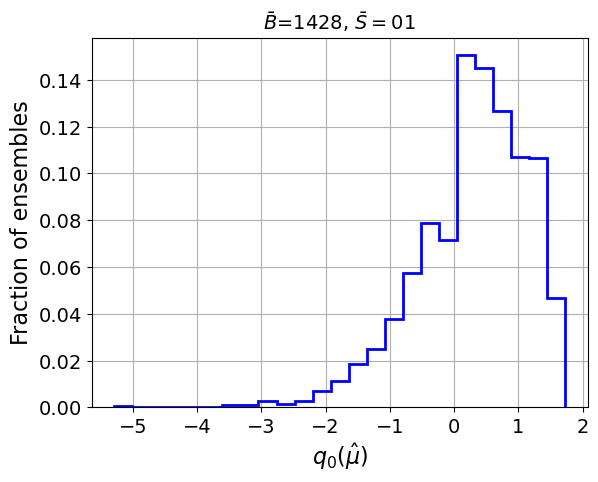

muhat mean:  0.08075481798715205
median q_muhat_KDE:  0.3801964100081726
Z_KDE:  0.616600689269946
Z_KDE mu=0:  0.616600689269946
std Z_KDE:  0.41120731101333874
std Z_KDE mu=0:  0.4140391120681589

 -------------------------------- 

B_expected:  1428
S_expected:  3
S/$\sqrt{B}$:  0.07938841860374447
n_ensembles (initial):  2000

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take long... 



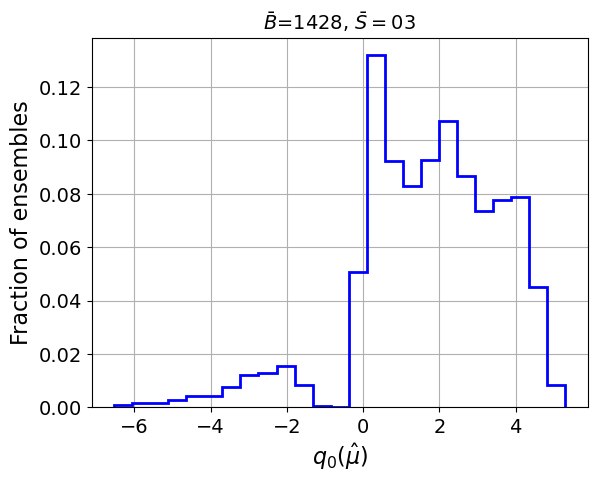

muhat mean:  0.14154175588865095
median q_muhat_KDE:  1.8792428328371953
Z_KDE:  1.3708547818194294
Z_KDE mu=0:  1.3708547818194294
std Z_KDE:  0.5304333079860862
std Z_KDE mu=0:  0.5508945018443534

 -------------------------------- 

B_expected:  1428
S_expected:  5
S/$\sqrt{B}$:  0.13231403100624078
n_ensembles (initial):  2000

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1866

 This may take long... 



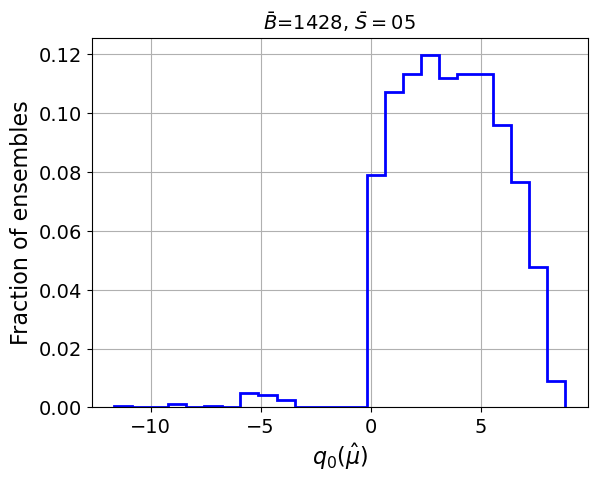

muhat mean:  0.1339764201500536
median q_muhat_KDE:  3.620552642709897
Z_KDE:  1.9027749847814104
Z_KDE mu=0:  1.9027749847814104
std Z_KDE:  0.5753815593204715
std Z_KDE mu=0:  0.6178517217215205

 -------------------------------- 

B_expected:  1428
S_expected:  7
S/$\sqrt{B}$:  0.18523964340873708
n_ensembles (initial):  2000

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take long... 



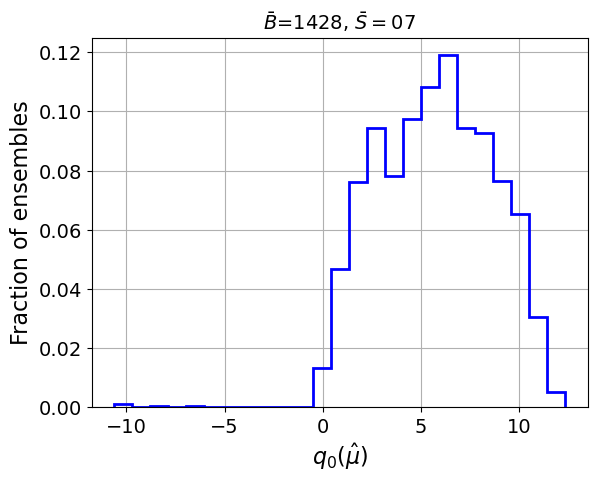

muhat mean:  0.11014997321906804
median q_muhat_KDE:  5.749660375315212
Z_KDE:  2.397844943968482
Z_KDE mu=0:  2.397701634424936
std Z_KDE:  0.5929725118591567
std Z_KDE mu=0:  0.6547563944993119

 -------------------------------- 

B_expected:  1428
S_expected:  10
S/$\sqrt{B}$:  0.26462806201248157
n_ensembles (initial):  2000

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take long... 



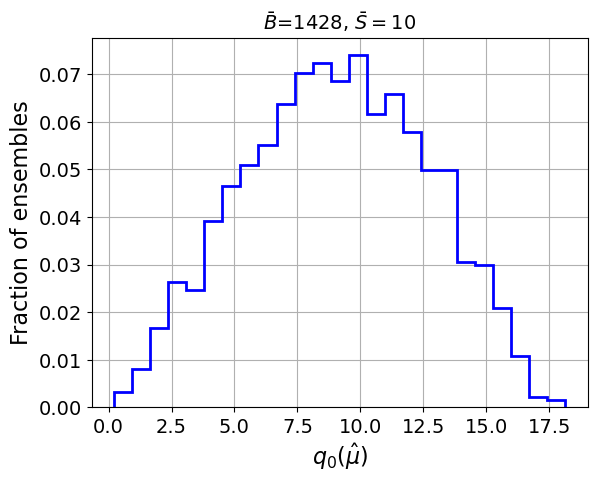

muhat mean:  0.07975361542581684
median q_muhat_KDE:  9.07664419589182
Z_KDE:  3.0127469518517183
Z_KDE mu=0:  3.0139346271084544
std Z_KDE:  0.5935313566573754
std Z_KDE mu=0:  0.6688790489091377

 -------------------------------- 

B_expected:  1428
S_expected:  20
S/$\sqrt{B}$:  0.5292561240249631
n_ensembles (initial):  2000

 If  289  =  177    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take long... 



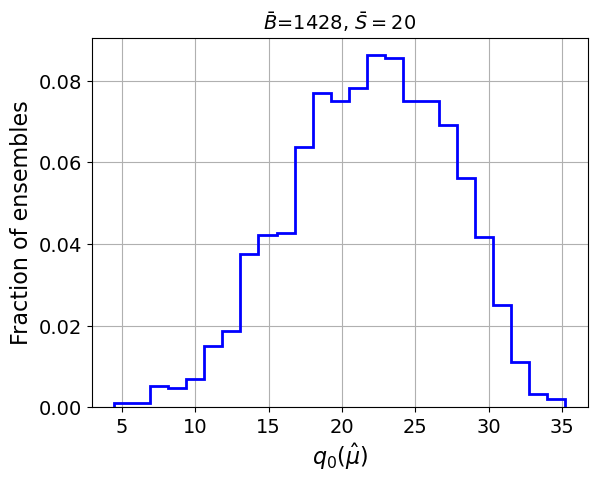

muhat mean:  0.04502141327623127
median q_muhat_KDE:  22.146886294879245
Z_KDE:  4.706047842391665
Z_KDE mu=0:  4.706047842391665
std Z_KDE:  0.5655270511986211
std Z_KDE mu=0:  0.6324223470578173

 -------------------------------- 

B_expected:  1428
S_expected:  50
S/$\sqrt{B}$:  1.3231403100624077
n_ensembles (initial):  2000

 If  295  =  178    then the proposed range has to be extended
n_ensembles (actual):  1863

 This may take long... 



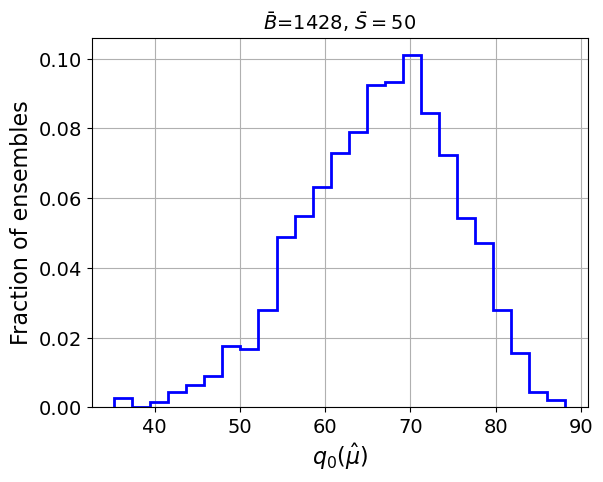

muhat mean:  0.025147611379495435
median q_muhat_KDE:  67.02957597199486
Z_KDE:  8.18715921257153
Z_KDE mu=0:  8.189319847008388
std Z_KDE:  0.5319549364647138
std Z_KDE mu=0:  0.5648157222937704

 -------------------------------- 



In [28]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

In [29]:
print(store_muhat_mean_MLL_KDE)

print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_Z_MLL_KDE_std)
print(store_Z_MLL_KDE_std_mu0)

[0.08075481798715205, 0.14154175588865095, 0.1339764201500536, 0.11014997321906804, 0.07975361542581684, 0.04502141327623127, 0.025147611379495435]
[0.616600689269946, 1.3708547818194294, 1.9027749847814104, 2.397844943968482, 3.0127469518517183, 4.706047842391665, 8.18715921257153]
[0.616600689269946, 1.3708547818194294, 1.9027749847814104, 2.397701634424936, 3.0139346271084544, 4.706047842391665, 8.189319847008388]
[0.41120731101333874, 0.5304333079860862, 0.5753815593204715, 0.5929725118591567, 0.5935313566573754, 0.5655270511986211, 0.5319549364647138]
[0.4140391120681589, 0.5508945018443534, 0.6178517217215205, 0.6547563944993119, 0.6688790489091377, 0.6324223470578173, 0.5648157222937704]


In [16]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.08075481798715205, 0.14154175588865095, 0.1339764201500536, 0.11014997321906804, 0.07975361542581684, 0.04502141327623127, 0.025147611379495435]

store_Z_MLL_KDE = [0.616600689269946, 1.3708547818194294, 1.9027749847814104, 2.397844943968482, 3.0127469518517183, 4.706047842391665, 8.18715921257153]
store_Z_MLL_KDE_mu0 = [0.616600689269946, 1.3708547818194294, 1.9027749847814104, 2.397701634424936, 3.0139346271084544, 4.706047842391665, 8.189319847008388]

store_Z_MLL_KDE_std = [0.41120731101333874, 0.5304333079860862, 0.5753815593204715, 0.5929725118591567, 0.5935313566573754, 0.5655270511986211, 0.5319549364647138]
store_Z_MLL_KDE_std_mu0 = [0.4140391120681589, 0.5508945018443534, 0.6178517217215205, 0.6547563944993119, 0.6688790489091377, 0.6324223470578173, 0.5648157222937704]

In [17]:
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

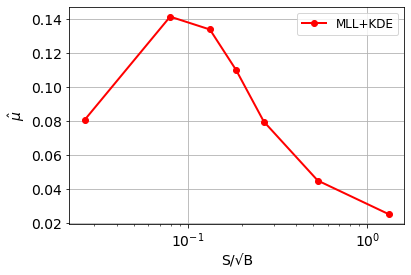

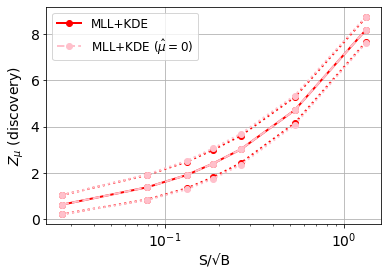

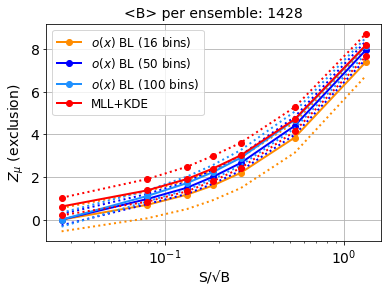

In [18]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0, '--o', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')
plt.plot(posX, store_Z_MLL_KDE_mu0_plus, ':o', color='pink', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0_min, ':o', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Interpolate

In [19]:
# if Z < 0 -> Z=0

store_Z_bins_XG_16bins = [0 if i < 0 else i for i in store_Z_bins_XG_16bins]
store_Z_bins_XG_16bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_plus]
store_Z_bins_XG_16bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_min]

store_Z_bins_XG_50bins = [0 if i < 0 else i for i in store_Z_bins_XG_50bins]
store_Z_bins_XG_50bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_plus]
store_Z_bins_XG_50bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_min]

store_Z_bins_XG_100bins = [0 if i < 0 else i for i in store_Z_bins_XG_100bins]
store_Z_bins_XG_100bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_plus]
store_Z_bins_XG_100bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_min]

store_Z_MLL_KDE = [0 if i < 0 else i for i in store_Z_MLL_KDE]
store_Z_MLL_KDE_plus = [0 if i < 0 else i for i in store_Z_MLL_KDE_plus]
store_Z_MLL_KDE_min = [0 if i < 0 else i for i in store_Z_MLL_KDE_min]

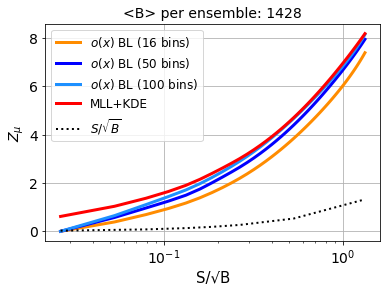

In [20]:
  
# Interpolation, cubic
f_16bins = interp1d(posX, store_Z_bins_XG_16bins, kind='cubic')
f_16bins_plus = interp1d(posX, store_Z_bins_XG_16bins_plus, kind='cubic')
f_16bins_min = interp1d(posX, store_Z_bins_XG_16bins_min, kind='cubic')

f_50bins = interp1d(posX, store_Z_bins_XG_50bins, kind='cubic')
f_50bins_plus = interp1d(posX, store_Z_bins_XG_50bins_plus, kind='cubic')
f_50bins_min = interp1d(posX, store_Z_bins_XG_50bins_min, kind='cubic')

f_100bins = interp1d(posX, store_Z_bins_XG_100bins, kind='cubic')
f_100bins_plus = interp1d(posX, store_Z_bins_XG_100bins_plus, kind='cubic')
f_100bins_min = interp1d(posX, store_Z_bins_XG_100bins_min, kind='cubic')

f_MLL_KDE = interp1d(posX, store_Z_MLL_KDE, kind='cubic')
f_MLL_KDE_plus = interp1d(posX, store_Z_MLL_KDE_plus, kind='cubic')
f_MLL_KDE_min = interp1d(posX, store_Z_MLL_KDE_min, kind='cubic')



# x to plot
plotX = np.linspace(min(posX), max(posX), num=50, endpoint=True)



plt.figure()
lw = 2

plt.plot(plotX, f_16bins(plotX), '-', color='darkorange', lw=3, label=r'$o(x)$ BL (16 bins)')
plt.plot(plotX, f_50bins(plotX), '-', color='blue', lw=3, label=r'$o(x)$ BL (50 bins)')
plt.plot(plotX, f_100bins(plotX), '-', color='dodgerblue', lw=3, label=r'$o(x)$ BL (100 bins)')
plt.plot(plotX, f_MLL_KDE(plotX), '-', color='red', lw=3, label='MLL+KDE')
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.ylim([0., 6])
#plt.xlim([0.06, 10])
#plt.ylim([0., 3])
#plt.xlim([0.1, 0.2])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [21]:
# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solve(fn, value, x=0.1, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

In [22]:
# We need the ratio of the fiducial cross-sections for different values of beta to rescale

beta = [0,0.1,0.3,0.5,0.7,0.9,1]

# m_LQ = [ 800, 1000, 1200, 1400, 1600, 1800 ]  GeV
ind_mass = 2

fidcross_beta00 = [0.1271808, 0.027032160000000003, 0.00770688, 0.001878312, 0.0005908139999999999, 0.00017041759999999998]
fidcross_beta01 = [0.3163628, 0.0741753, 0.01952626, 0.0044892, 0.0016499700000000002, 0.00046830800000000007]
fidcross_beta03 = [0.559062, 0.13798409999999997, 0.03652792, 0.01062024, 0.002733768, 0.0008702760000000001]
fidcross_beta05 = [0.74664, 0.1822585, 0.04825368, 0.012417530000000001, 0.0032513399999999997, 0.001112082]
fidcross_beta07 = [0.6483749999999999, 0.165285, 0.04282562, 0.01281222, 0.003864048, 0.001097392]
fidcross_beta09 = [0.43799099999999996, 0.113778, 0.03572283, 0.010101599999999999, 0.0030826390000000003, 0.0008606400000000001]
fidcross_beta1 = [0.26443679999999997, 0.08237423999999999, 0.026599559999999994, 0.007674479999999999, 0.00222552, 0.0007910968]


S00 = round(139 * crossfidNP) * (fidcross_beta00[ind_mass]/fidcross_beta05[ind_mass])
S01 = round(139 * crossfidNP) * (fidcross_beta01[ind_mass]/fidcross_beta05[ind_mass])
S03 = round(139 * crossfidNP) * (fidcross_beta03[ind_mass]/fidcross_beta05[ind_mass])
S05 = round(139 * crossfidNP) * (fidcross_beta05[ind_mass]/fidcross_beta05[ind_mass])
S07 = round(139 * crossfidNP) * (fidcross_beta07[ind_mass]/fidcross_beta05[ind_mass])
S09 = round(139 * crossfidNP) * (fidcross_beta09[ind_mass]/fidcross_beta05[ind_mass])
S1 = round(139 * crossfidNP) * (fidcross_beta1[ind_mass]/fidcross_beta05[ind_mass])


S_exp_LQ = [S00,S01,S03,S05,S07,S09,S1]

print(S_exp_LQ)

[1.9165908175293573, 4.855901560254058, 9.083971212143819, 12.0, 10.65011912044843, 8.883756845073783, 6.614930094450825]


In [23]:
# Finally, the value of Z for each value of beta, for this particular LQ

results_16bins_beta = []
results_16bins_beta_plus = []
results_16bins_beta_min = []

results_50bins_beta = []
results_50bins_beta_plus = []
results_50bins_beta_min = []

results_100bins_beta = []
results_100bins_beta_plus = []
results_100bins_beta_min = []

results_MLL_KDE_beta = []
results_MLL_KDE_beta_plus = []
results_MLL_KDE_beta_min = []



for signal in S_exp_LQ:    
    results_16bins_beta.append( f_16bins(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_plus.append( f_16bins_plus(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_min.append( f_16bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_50bins_beta.append( f_50bins(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_plus.append( f_50bins_plus(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_min.append( f_50bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_100bins_beta.append( f_100bins(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_plus.append( f_100bins_plus(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_min.append( f_100bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_MLL_KDE_beta.append( f_MLL_KDE(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_plus.append( f_MLL_KDE_plus(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_min.append( f_MLL_KDE_min(signal/(B_expected**0.5)).tolist() )

In [24]:
print( results_16bins_beta )
print( results_16bins_beta_plus )
print( results_16bins_beta_min )

print( results_50bins_beta )
print( results_50bins_beta_plus )
print( results_50bins_beta_min )

print( results_100bins_beta )
print( results_100bins_beta_plus )
print( results_100bins_beta_min )

print( results_MLL_KDE_beta )
print( results_MLL_KDE_beta_plus )
print( results_MLL_KDE_beta_min )

np.savetxt('saved-results/LQdown1200GeV.txt', [results_16bins_beta,
                                            results_16bins_beta_plus,
                                            results_16bins_beta_min,
                                            results_50bins_beta,
                                            results_50bins_beta_plus,
                                            results_50bins_beta_min,
                                            results_100bins_beta,
                                            results_100bins_beta_plus,
                                            results_100bins_beta_min,
                                            results_MLL_KDE_beta,
                                            results_MLL_KDE_beta_plus,
                                            results_MLL_KDE_beta_min])

[0.35901771447798125, 1.1385329141884857, 2.0222896208987735, 2.5608075293921795, 2.316751844172497, 1.9836150116229314, 1.5224895045453783]
[0.9483834106938214, 1.8118144255629292, 2.7303972242624015, 3.2914529099567718, 3.0392000228663596, 2.6896665121102488, 2.209465079791033]
[-0.04643836555770242, 0.46182219539121455, 1.3115021235130468, 1.8346707334058012, 1.5960773610468297, 1.2744208380772684, 0.8385699835540543]
[0.5337603601692709, 1.4585702790648503, 2.474425553936822, 3.039123749946892, 2.7830852712565055, 2.4333956096638203, 1.9125398500722308]
[0.769580016147246, 1.7411579115048843, 2.8261108722019914, 3.416000678875427, 3.149142689910518, 2.783032855449387, 2.2324471167550675]
[0.38673994865637834, 1.1743268820455302, 2.121446270900523, 2.6644237539730753, 2.417884266908814, 2.0822409500584746, 1.5941081740325882]
[0.6039419585903, 1.6731994314958345, 2.7088675874504125, 3.30205840775101, 3.0345700025498115, 2.665653327943795, 2.1337944247415126]
[0.8714749368296035, 1.9

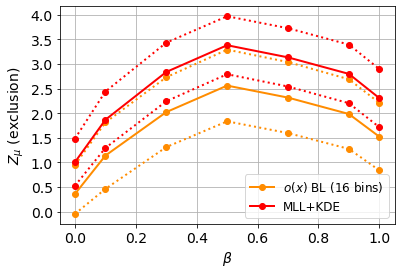

In [25]:
plt.figure()
lw = 2

plt.plot(beta, results_16bins_beta, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
plt.plot(beta, results_16bins_beta_plus, ':o', color='darkorange', lw=lw) 
plt.plot(beta, results_16bins_beta_min, ':o', color='darkorange', lw=lw) 

# plt.plot(beta, results_50bins_beta, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
# plt.plot(beta, results_50bins_beta_plus, ':o', color='blue', lw=lw) 
# plt.plot(beta, results_50bins_beta_min, ':o', color='blue', lw=lw) 

# plt.plot(beta, results_100bins_beta, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')
# plt.plot(beta, results_100bins_beta_plus, ':o', color='dodgerblue', lw=lw) 
# plt.plot(beta, results_100bins_beta_min, ':o', color='dodgerblue', lw=lw) 

plt.plot(beta, results_MLL_KDE_beta, '-o', color='red', lw=lw, label=r'MLL+KDE')
plt.plot(beta, results_MLL_KDE_beta_plus, ':o', color='red', lw=lw) 
plt.plot(beta, results_MLL_KDE_beta_min, ':o', color='red', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
#plt.xscale('log')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(fontsize=12)
plt.show()